In [8]:
import numpy as np
import networkx as nx
import polars as pl
import matplotlib.pyplot as plt
import random
from collections import defaultdict

In [9]:
# reproducible RNG
random.seed(42)
np.random.seed(42)

# STEP 1: Clean up data/rename and prepare for simulation

# load datasets 
nurse_df = pl.read_csv("nurse_population.txt", separator=" ", has_header=True, ignore_errors=True)
pat_df   = pl.read_csv("patient_population.txt",  separator=" ", has_header=True, ignore_errors=True)

# rename header columns to maintain consistency 
nurse_df = nurse_df.rename({"#id": "agent_id"}).with_columns(pl.lit("NURSE").alias("role"))  # nurses with role
pat_df   = pat_df.rename({"#id": "agent_id"}).with_columns(pl.lit("PATIENT").alias("role"))  # patients with role
agents_df = pl.concat([nurse_df, pat_df], how="vertical_relaxed")  # combine nurse and patient tables
agents_df = agents_df.with_columns(pl.col("agent_id").cast(pl.Int64, strict=False))  # ensure agent_id is integer for everyone
agents = {r["agent_id"]: r["role"] for r in agents_df.iter_rows(named=True)}  # map id directly to role string

# load and merge visits 
v_cols = {"#Person": "agent_id", "location": "location_id", "StartTime": "t0", "EndTime": "t1"}  # rename mapping for visits
v1 = pl.read_csv("visits_m9.txt",       separator=" ", has_header=True, ignore_errors=True).rename(v_cols)  # patient visits
v2 = pl.read_csv("nurse_visits_m9.txt", separator=" ", has_header=True, ignore_errors=True).rename(v_cols)  # nurse visits


visits = (  # combined visits for both roles
    pl.concat([v1, v2], how="vertical_relaxed")  # stack patient and nurse visits
      .select(["agent_id", "location_id", "t0", "t1"])  # keep needed columns
      .with_columns([
          pl.col("agent_id").cast(pl.Int64, strict=False),  # cast ids to integer to match agents_df
          pl.col("t0").cast(pl.Int64, strict=False),  # cast start time to integer
          pl.col("t1").cast(pl.Int64, strict=False),  # cast end time to integer
      ])
      .drop_nulls(["t0"])  # require a valid start time
      .filter((pl.col("t1") == 0) | (pl.col("t1") > pl.col("t0")))  # keep patient rows (t1==0) or valid intervals
)



# test to make sure everything has been imported
print(nurse_df)
print(pat_df)
print(agents_df) # nurses and patients together

print(v1) 
print(v2)
print(visits)

shape: (12, 7)
┌──────────┬───────┬─────────┬──────┬──────┬──────┬───────┐
│ agent_id ┆ group ┆ homeloc ┆ fsm0 ┆ fsm1 ┆ demo ┆ role  │
│ ---      ┆ ---   ┆ ---     ┆ ---  ┆ ---  ┆ ---  ┆ ---   │
│ i64      ┆ i64   ┆ i64     ┆ i64  ┆ i64  ┆ i64  ┆ str   │
╞══════════╪═══════╪═════════╪══════╪══════╪══════╪═══════╡
│ 10000    ┆ 1     ┆ 9910000 ┆ 1    ┆ 2    ┆ 1    ┆ NURSE │
│ 10001    ┆ 1     ┆ 9910001 ┆ 1    ┆ 2    ┆ 1    ┆ NURSE │
│ 10002    ┆ 1     ┆ 9910002 ┆ 1    ┆ 2    ┆ 1    ┆ NURSE │
│ 10003    ┆ 1     ┆ 9910003 ┆ 1    ┆ 2    ┆ 1    ┆ NURSE │
│ 10004    ┆ 1     ┆ 9910004 ┆ 1    ┆ 2    ┆ 1    ┆ NURSE │
│ …        ┆ …     ┆ …       ┆ …    ┆ …    ┆ …    ┆ …     │
│ 10007    ┆ 2     ┆ 9910007 ┆ 1    ┆ 2    ┆ 1    ┆ NURSE │
│ 10008    ┆ 2     ┆ 9910008 ┆ 1    ┆ 2    ┆ 1    ┆ NURSE │
│ 10009    ┆ 2     ┆ 9910009 ┆ 1    ┆ 2    ┆ 1    ┆ NURSE │
│ 10010    ┆ 2     ┆ 9910010 ┆ 1    ┆ 2    ┆ 1    ┆ NURSE │
│ 10011    ┆ 2     ┆ 9910011 ┆ 1    ┆ 2    ┆ 1    ┆ NURSE │
└──────────┴───────┴─────

In [10]:
# STEP 2: Convert the given times into days

DAY = 24 * 60 * 60  # seconds in a day

visits_day = (  # create a daily presence table from visits
    visits
    .with_columns([
        (pl.col("t0") // DAY).alias("day"),  # convert start time to day index
        (pl.col("t1") // DAY).alias("day1"),  # convert end time to day index
    ])
    .with_columns(pl.col("day").alias("d"))  # convenience column 'd' for grouping
    .select(["agent_id", "location_id", "d"])  # keep agent id, room id, and day
    .unique()  # ensure each agent-room-day combination appears only once
)

# STEP 3: group agents by day and location

roster = {}  # key: (day, location_id), value: list of agent IDs present there on that day

for (d, loc), g in visits_day.group_by(["d", "location_id"]):  # group by day and location
    roster[(int(d), str(loc))] = [aid for (aid,) in g.select("agent_id").iter_rows()]  # collect all agent_ids in that group

print(roster)  # show the roster dictionary

{(117, '1115'): [40040], (9, '973'): [10002], (27, '976'): [10010, 10004], (100, '5038'): [40022], (100, '993'): [40022], (13, '978'): [10011, 10005], (204, '5117'): [40019], (112, '5185'): [40020], (305, '5122'): [40038], (20, '9910002'): [10002], (0, '1'): [10002, 10004, 10007, 10008, 10009, 10005, 10006, 10003, 10011, 10001, 10000, 10010], (99, '5302'): [40035], (25, '9910002'): [10002], (4, '975'): [10009], (23, '978'): [10011], (22, '9910004'): [10004], (96, '5187'): [40015], (26, '970'): [10007], (109, '5034'): [40021], (9, '9910001'): [10001], (26, '977'): [10010], (102, '5186'): [40036], (105, '878'): [40061], (97, '5050'): [40017], (104, '5120'): [40054], (109, '5183'): [40016], (17, '9910000'): [10000], (4, '9910005'): [10005], (27, '972'): [10002], (23, '9910000'): [10000], (10, '975'): [10009, 10003], (117, '986'): [40009], (6, '9910002'): [10002], (94, '968'): [40032], (25, '9910008'): [10008], (27, '9910003'): [10003], (19, '9910010'): [10010], (94, '1120'): [40032], (99,

In [11]:
# STEP 4: preparing for simulation

# use ALL days present in the data; seed at earliest active day 
days = sorted({int(d) for (d, _) in roster.keys()})
EARLY = days[0]

# initialize the states (S/I/R)
agent_ids = set(agents_df["agent_id"].to_list()) # groups all patients and nurses together into agent_ids
state = {aid: "S" for aid in agent_ids} # create a dict that maps each agent to a disease state. initially, everyone starts as out S/susceptible


# creating initial infections (prefer patient seeds)

patient_ids = set(  # set of all agent_ids whose role is PATIENT
    agents_df.filter(pl.col("role") == "PATIENT")["agent_id"].to_list()
)

first_day_agents = {  # agents present on the earliest active day
    a for (d, _), ppl in roster.items() if d == EARLY for a in ppl
}
active_agents = {  # all agents that ever appear in the roster
    a for (_, _), ppl in roster.items() for a in ppl
}

patients_in_roster = active_agents & patient_ids  # patients that actually appear in the roster

if patients_in_roster:  # if there is at least one patient in the roster
    seed_pool = list(patients_in_roster)  # choose seeds from patients only
else:  # fallback if somehow there are no patients
    seed_pool = list(first_day_agents if first_day_agents else active_agents if active_agents else agent_ids)  # previous logic

for a in random.sample(seed_pool, min(3, len(seed_pool))):  # randomly infect up to 3 agents from the seed pool
    state[a] = "I"  # mark those agents as initially infected



# person-to-location parameters
beta_env = 0.02              # sets how infectious contaminated rooms are AKA the transmission rate
shed_rate = {"NURSE": 0.5, "PATIENT": 1.0} # how much each infected person contaminates the rooms 
half_life_days = 45          # how long C.diff spores persist in rooms
decay = 1.0 - (0.5 ** (1.0 / half_life_days))  # daily proportion of spores lost 
recovery = 1/14                 # recovery rate of infected people 


In [12]:
# STEP 5: finally the simulation

# creates dict that keeps track of how contaminated a room is 
room_load = defaultdict(float)

# creates an empty list so we can collect the simulation daily summary data 
daily_stats = []


# SIMULATION
for d in days:
    # 1) shedding: infected present today add to room load
    for (day_key, room), people in roster.items():
        if day_key != d:
            continue
        add = 0.0
        for a in people:  # loop over all agents present in this room on this day
            if state.get(a) == "I":  # if this agent is currently infected
                role = agents.get(a, "PATIENT")  # look up their role; default to PATIENT if unknown
                add += shed_rate.get(role, 1.0)  # add the appropriate shedding amount for this role
        if add:
            room_load[room] += add

    # 2) exposure from room environment
    for (day_key, room), people in roster.items():
        if day_key != d:
            continue
        L = room_load.get(room, 0.0)
        if L <= 0:
            continue
        p_inf = 1.0 - np.exp(-beta_env * L)
        for a in people:
            if state.get(a, "S") == "S" and random.random() < p_inf:  # treat unknown agents as susceptible by default
                state[a] = "I"

    # 3) recoveries (SIR); set recovery=0 to get SI
    for a in list(state.keys()):
        if state[a] == "I" and random.random() < recovery:
            state[a] = "R"

    # 4) environmental decay (once per day)
    for r in list(room_load.keys()):
        room_load[r] *= (1.0 - decay)

    # record counts
    S = sum(s == "S" for s in state.values())
    I = sum(s == "I" for s in state.values())
    R = sum(s == "R" for s in state.values())
    daily_stats.append({"day": d, "S": S, "I": I, "R": R})

# RESULTS
epi = pl.DataFrame(daily_stats)

print("Epidemic curve (first 10 days with activity):")
print(epi.head(10)) # printing the first 10 days
print("Epidemic curve (last 10 days with activity):")
print(epi.tail(10)) # printing the last days/end of infection period 

Epidemic curve (first 10 days with activity):
shape: (10, 4)
┌─────┬─────┬─────┬─────┐
│ day ┆ S   ┆ I   ┆ R   │
│ --- ┆ --- ┆ --- ┆ --- │
│ i64 ┆ i64 ┆ i64 ┆ i64 │
╞═════╪═════╪═════╪═════╡
│ 0   ┆ 60  ┆ 3   ┆ 0   │
│ 1   ┆ 60  ┆ 3   ┆ 0   │
│ 2   ┆ 58  ┆ 4   ┆ 1   │
│ 3   ┆ 58  ┆ 4   ┆ 1   │
│ 4   ┆ 57  ┆ 5   ┆ 1   │
│ 5   ┆ 57  ┆ 5   ┆ 1   │
│ 6   ┆ 56  ┆ 5   ┆ 2   │
│ 7   ┆ 55  ┆ 6   ┆ 2   │
│ 8   ┆ 53  ┆ 8   ┆ 2   │
│ 9   ┆ 53  ┆ 8   ┆ 2   │
└─────┴─────┴─────┴─────┘
Epidemic curve (last 10 days with activity):
shape: (10, 4)
┌─────┬─────┬─────┬─────┐
│ day ┆ S   ┆ I   ┆ R   │
│ --- ┆ --- ┆ --- ┆ --- │
│ i64 ┆ i64 ┆ i64 ┆ i64 │
╞═════╪═════╪═════╪═════╡
│ 166 ┆ 51  ┆ 1   ┆ 16  │
│ 204 ┆ 51  ┆ 1   ┆ 16  │
│ 219 ┆ 51  ┆ 1   ┆ 16  │
│ 237 ┆ 51  ┆ 0   ┆ 17  │
│ 261 ┆ 51  ┆ 0   ┆ 17  │
│ 299 ┆ 51  ┆ 0   ┆ 17  │
│ 305 ┆ 51  ┆ 0   ┆ 17  │
│ 313 ┆ 51  ┆ 0   ┆ 17  │
│ 352 ┆ 51  ┆ 0   ┆ 17  │
│ 353 ┆ 51  ┆ 0   ┆ 17  │
└─────┴─────┴─────┴─────┘


* So I think we can change things to see how different factors affect the spread of C.diff. 
* We could change:
* 1. We can clean the rooms more aka increase decay
* 2. We can change beta_env
etc

/var/folders/08/9q0_t08d7c536fkv17vb6nfw0000gn/T/ipykernel_43495/2074627005.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=True, header=0)  # read whitespace-separated file with header
/var/folders/08/9q0_t08d7c536fkv17vb6nfw0000gn/T/ipykernel_43495/2074627005.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=True, header=0)  # read whitespace-separated file with header


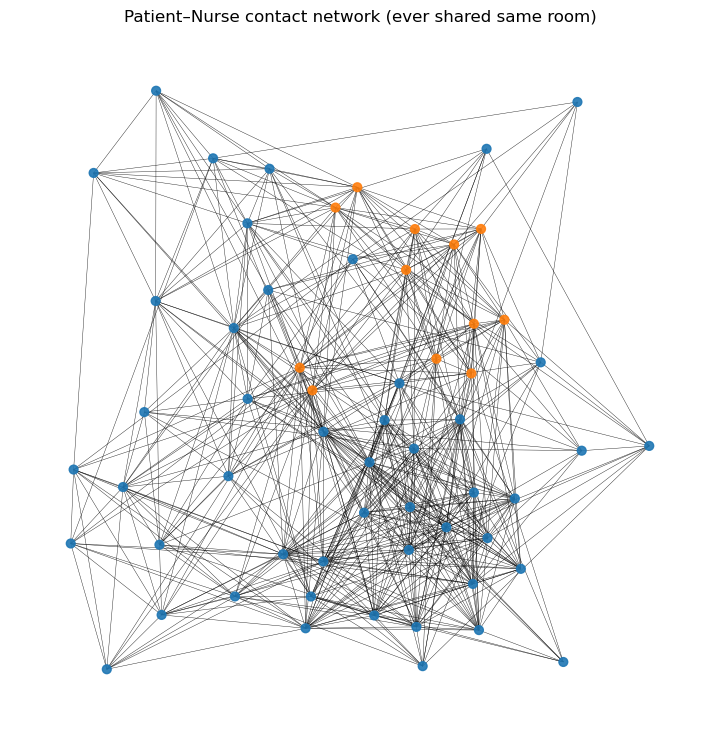

There are 75 nodes
There are 588 edges
Average degree of network is: 15.68
Density of network: 0.2118918918918919
Number of connected components: 9
Sizes of each component: [1, 67, 1, 1, 1, 1, 1, 1, 1]
Top 5 nodes by Eigenvector Centrality: [40022, 40045, 40049, 40057, 40040]
Top 5 nodes by Betweenness Centrality: [40045, 40051, 40022, 40023, 10001]
Top 5 nodes by Closeness Centrality: [40022, 40045, 40049, 40057, 40018]
PATIENT
PATIENT


In [13]:
import pandas as pd 
import networkx as nx 
import matplotlib.pyplot as plt

def load_visits_anytime(path, role):  # helper to load one visits file and tag role
    df = pd.read_csv(path, delim_whitespace=True, header=0)  # read whitespace-separated file with header
    df.columns = [c.lstrip("#") for c in df.columns]  # strip leading # from column names
    df["role"] = role  # add a role column 
    return df[["Person", "location", "role"]]  # keep only person id, location id, and role

pat = load_visits_anytime("visits_m9.txt", "PATIENT")  # load all patient visits
nur = load_visits_anytime("nurse_visits_m9.txt", "NURSE")  # load all nurse visits

visits = pd.concat([pat, nur], ignore_index=True)  # combine patient and nurse visit records

G = nx.Graph()  # create an empty undirected graph

for pid, role in visits[["Person", "role"]].drop_duplicates().itertuples(index=False):  # loop over unique people with roles
    G.add_node(pid, role=role)  # add each person as a node with their role attribute

for loc, grp in visits.groupby("location"):  # group visits by location (room)
    people = grp["Person"].unique()  # list of unique people who ever used this room
    if len(people) < 2:  # if fewer than two people used this room
        continue  # skip because it cannot create an edge
    for i in range(len(people)):  # loop over indices for people in this room
        for j in range(i + 1, len(people)):  # loop over later indices to form pairs
            a, b = people[i], people[j]  # get the two person IDs
            if G.has_edge(a, b):  # if an edge between them already exists
                G[a][b]["weight"] += 1  # increase weight (another shared room)
            else:  # otherwise
                G.add_edge(a, b, weight=1)  # add a new edge with weight 1

if G.number_of_nodes() > 60:  # if the graph has many nodes
    deg_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)  # sort nodes by degree (descending)
    top_nodes = [n for n, d in deg_sorted[:60]]  # keep the 60 most connected nodes
    H = G.subgraph(top_nodes).copy()  # create a subgraph on those nodes
else:  # if the graph is small
    H = G  # use the full graph

node_colors = [  # choose a color for each node based on role
    "tab:blue" if H.nodes[n]["role"] == "PATIENT" else "tab:orange"
    for n in H.nodes()
]

pos = nx.spring_layout(H, seed=0)  # compute a layout for nodes using a force-directed algorithm

plt.figure(figsize=(7, 7))  # create a square figure for the network
nx.draw(H, pos, node_color=node_colors, node_size=40, alpha=0.9, width=0.3)  # draw nodes and edges with role colors
plt.title("Patient–Nurse contact network (ever shared same room)")  # add a descriptive title
plt.axis("off")  # hide axes for a cleaner look
plt.show()  # display the plot

# STATS

# number of nodes
n = G.number_of_nodes()
print(f"There are {n} nodes")

# number of edges
m = G.number_of_edges()
print(f"There are {m} edges")

# average degree
t_list = []
for i in G.nodes():
    t_list.append(G.degree[i])

md = sum(t_list) / n
print(f"Average degree of network is: {md}")

# network density
d = m / (n * (n - 1) / 2)
print(f"Density of network: {d}")

# number and size of connected components
components = list(nx.connected_components(G))
num_components = len(components)
sizes = [len(c) for c in components]

print(f"Number of connected components: {num_components}")
print(f"Sizes of each component: {sizes}")

# eigenvector centrality
ec = nx.eigenvector_centrality(G)
top_ec = sorted(ec, key=ec.get, reverse=True)[:5]
print("Top 5 nodes by Eigenvector Centrality:", top_ec)

# betweenness centrality 
bc = nx.betweenness_centrality(G)
top_bc = sorted(bc, key=bc.get, reverse=True)[:5]
print("Top 5 nodes by Betweenness Centrality:", top_bc)

# closeness centrality
cc = nx.closeness_centrality(G)
top_cc = sorted(cc, key=cc.get, reverse=True)[:5]
print("Top 5 nodes by Closeness Centrality:", top_cc)


print(G.nodes[40022]["role"])
print(G.nodes[40045]["role"])


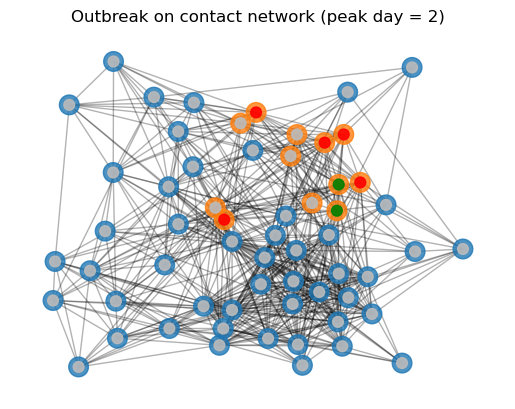

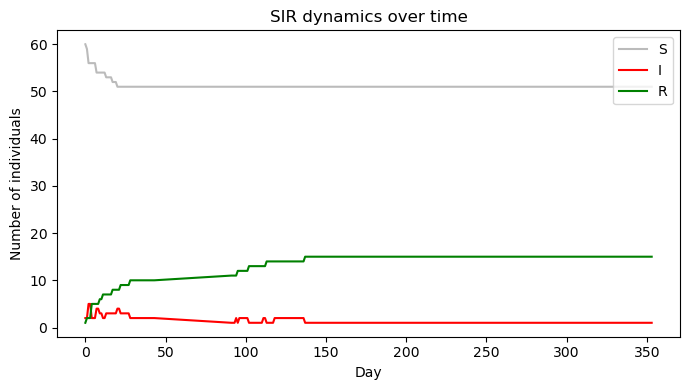

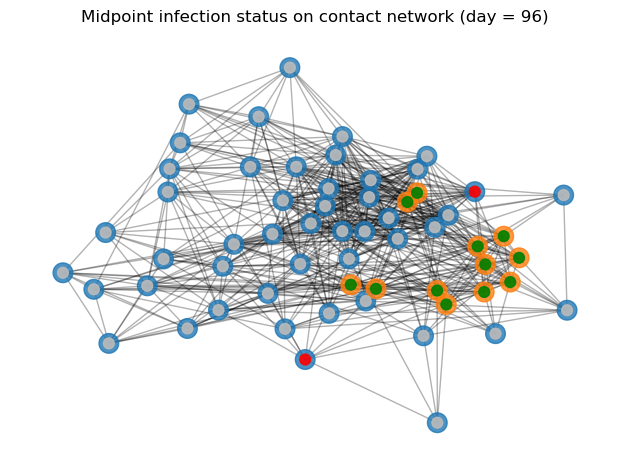

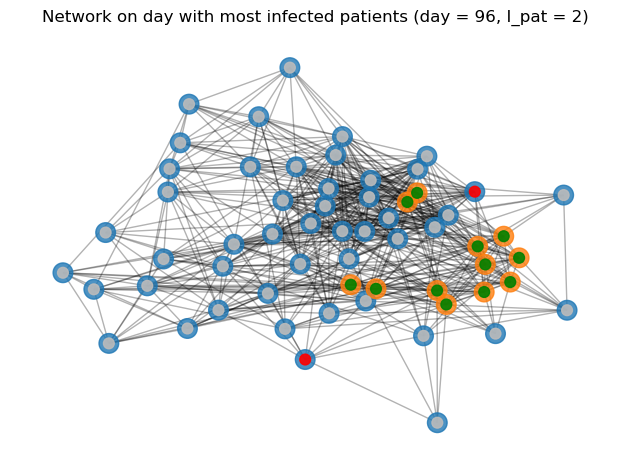

In [34]:
import numpy as np
import random 
from collections import defaultdict 
import pandas as pd 
import matplotlib.pyplot as plt
import networkx as nx 


agents_pd = agents_df.to_pandas()  # convert agents table from Polars to pandas
agents = dict(zip(agents_pd["agent_id"], agents_pd["role"]))  # map each agent to its role 

days = sorted({int(d) for (d, _) in roster.keys()})  # sorted list of all days present in the roster
EARLY = days[0]  # earliest day in the dataset
all_agents = set(agents.keys())  # set of all agent IDs from the population table
state = {a: "S" for a in all_agents}  # initialize everyone as susceptible

first_day_agents = {a for (d, _), ppl in roster.items() if d == EARLY for a in ppl}  # agents present on the first day
active_agents = {a for (_, _), ppl in roster.items() for a in ppl}  # agents that appear in any room on any day
seed_pool = list(first_day_agents or active_agents or all_agents)  # pool to choose initial infected from

for a in random.sample(seed_pool, min(3, len(seed_pool))):  # choose up to 3 random seeds from the pool
    state[a] = "I"  # mark those seed agents as infected

beta_env = 0.02  # environmental transmission parameter
shed_rate = {"NURSE": 0.5, "PATIENT": 1.0}  # role-specific shedding amounts
half_life_days = 45.0  # environmental half-life in days
decay = 1.0 - (0.5 ** (1.0 / half_life_days))  # per-day fractional decay from the half-life
recovery = 1.0 / 14.0  # daily recovery probability (approx 2-week infectious period)

room_load = defaultdict(float)  # contamination level for each room
daily_stats = []  # list to store S/I/R counts each day
states_by_day = {}  # dictionary to store a snapshot of all agent states for each day

for d in days:  # loop over each simulation day
    for (day_key, room), people in roster.items():  # iterate over every (day, room) in the roster
        if day_key != d:  # skip rooms that are not for the current day
            continue  # go to next roster entry
        for a in people:  # loop over people in this room on this day
            if state.get(a, "S") == "I":  # if this person is currently infected
                role = agents.get(a, "PATIENT")  # get their role 
                room_load[room] += shed_rate[role]  # add role-specific shedding to the room contamination

    for (day_key, room), people in roster.items():  # second pass to handle infections
        if day_key != d:  # again skip rooms for other days
            continue  # go to next roster entry
        L = room_load[room]  # contamination level in this room
        p_inf = 1.0 - np.exp(-beta_env * L)  # infection probability from environmental dose–response
        for a in people:  # loop over people in this room
            if state.get(a, "S") == "S" and random.random() < p_inf:  # susceptible and random draw below p_inf
                state[a] = "I"  # agent becomes infected

    for a in list(state.keys()):  # loop over all agents for recovery updates
        if state[a] == "I" and random.random() < recovery:  # infected agents recover with probability gamma
            state[a] = "R"  # move to recovered state

    for r in room_load:  # loop over all rooms that have contamination
        room_load[r] *= (1.0 - decay)  # apply exponential decay to the contamination level

    S_count = sum(s == "S" for s in state.values())  # total susceptible count
    I_count = sum(s == "I" for s in state.values())  # total infected count
    R_count = sum(s == "R" for s in state.values())  # total recovered count

    daily_stats.append({"day": d, "S": S_count, "I": I_count, "R": R_count})  # store S/I/R for this day
    
    states_by_day[d] = state.copy()  # store a snapshot of all agent states for this day

epi = pd.DataFrame(daily_stats)  # convert daily stats to a pandas DataFrame
peak_idx = epi["I"].idxmax()  # index of the day with maximum number of infected
peak_day = epi.loc[peak_idx, "day"]  # actual day value at peak infection
state_peak = states_by_day[peak_day]  # snapshot of all agent states on the peak day

if G.number_of_nodes() > 60:  # if the contact network is large
    deg_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)  # sort nodes by degree
    top_nodes = [n for n, d in deg_sorted[:60]]  # choose the 60 most connected nodes
    H = G.subgraph(top_nodes).copy()  # create a subgraph on those nodes
else:
    H = G  # otherwise use the full contact network

pos = nx.spring_layout(H, seed=0)  # compute node positions for visualization

role_colors = [  # base color for each node showing role (blue=PATIENT, orange=NURSE)
    "tab:blue" if H.nodes[n]["role"] == "PATIENT" else "tab:orange"
    for n in H.nodes()
]

nx.draw_networkx_nodes(H, pos, node_color=role_colors, node_size=200, alpha=0.8)  # draw large nodes in role colors
nx.draw_networkx_edges(H, pos, alpha=0.3)  # draw edges between nodes

state_colors = []  # list of colors for the small inner dots showing infection state at peak day
for n in H.nodes():  # loop over nodes in the plotted subgraph
    s = state_peak.get(n, "S")  # get the infection state of this agent at peak day (default S)
    if s == "I":  # if currently infected
        state_colors.append("red")  # red inner dot for infected
    elif s == "R":  # if recovered by peak
        state_colors.append("green")  # green inner dot for recovered
    else:  # otherwise susceptible / never infected
        state_colors.append("#BBBBBB")  # white inner dot for susceptible

nx.draw_networkx_nodes(H, pos, node_color=state_colors, node_size=60, alpha=0.9)  # draw smaller inner nodes for infection state

plt.title(f"Outbreak on contact network (peak day = {peak_day})")  # title including peak day
plt.axis("off")  # hide axes for a cleaner network plot
plt.show()  # display the network figure

plt.figure(figsize=(7, 4))  # create a new figure for the S/I/R time series

plt.plot(epi["day"], epi["S"], color="#BBBBBB", label="S")  # plot susceptible counts over time as a gray line
plt.plot(epi["day"], epi["I"], color="red", label="I")      # plot infected counts over time as a red line
plt.plot(epi["day"], epi["R"], color="green", label="R")    # plot recovered counts over time as a green line

plt.xlabel("Day")  # label the x-axis
plt.ylabel("Number of individuals")  # label the y-axis
plt.title("SIR dynamics over time")  # title for the epidemic curve
plt.legend(loc="upper right")  # show legend identifying S, I, and R lines
plt.tight_layout()  # adjust layout so labels and title are not cut off
plt.show()  # display the line-plot figure


epi_pd = epi  # epi is already a pandas DataFrame here

infected_days = epi_pd.loc[epi_pd["I"] > 0, "day"].tolist()  # list of days with at least one infected person

if infected_days:  # if there is any infection at all
    mid_index = len(infected_days) // 2  # index of the midpoint among infected days
    mid_day = infected_days[mid_index]  # actual day value at the midpoint
else:  # fallback if somehow there are no infected days
    mid_day = days[len(days) // 2]  # use the overall middle day in the simulation

state_mid = states_by_day.get(mid_day, state)  # infection state snapshot on the midpoint day

# choose subgraph if contact network is large
if G.number_of_nodes() > 60:
    deg_sorted_mid = sorted(G.degree, key=lambda x: x[1])  # sort nodes by degree
    top_nodes_mid = [n for n, d in deg_sorted_mid[-60:]]  # keep the 60 most connected nodes
    H_mid = G.subgraph(top_nodes_mid).copy()  # midpoint subgraph
else:
    H_mid = G  # use full network

pos_mid = nx.spring_layout(H_mid, seed=0)  # layout for midpoint plot

role_colors_mid = [  # outer ring: role
    "tab:blue" if H_mid.nodes[n]["role"] == "PATIENT" else "tab:orange"
    for n in H_mid.nodes()
]

nx.draw_networkx_nodes(H_mid, pos_mid, node_color=role_colors_mid, node_size=200, alpha=0.8)  # draw outer nodes
nx.draw_networkx_edges(H_mid, pos_mid, alpha=0.3)  # draw edges

state_colors_mid = []  # inner dot: state on midpoint day
for n in H_mid.nodes():
    s = state_mid.get(n, "S")  # S/I/R on midpoint day
    if s == "I":
        state_colors_mid.append("red")  # infected
    elif s == "R":
        state_colors_mid.append("green")  # recovered
    else:
        state_colors_mid.append("#BBBBBB")  # still susceptible

nx.draw_networkx_nodes(H_mid, pos_mid, node_color=state_colors_mid, node_size=60, alpha=0.9)  # inner dots

plt.title(f"Midpoint infection status on contact network (day = {mid_day})")
plt.axis("off")
plt.tight_layout()
plt.show()


role_map = agents  # id -> role string (PATIENT or NURSE)

best_day = None  # variable to store the day with most infected patients
best_pat_I = -1  # track the maximum number of infected patients seen

for d, snapshot in states_by_day.items():  # loop over each day and its state snapshot
    I_pat = sum(  # count patients infected on this day
        (snapshot.get(a, "S") == "I") and (role_map.get(a, "PATIENT") == "PATIENT")
        for a in snapshot
    )
    if I_pat > best_pat_I:  # if this day has more infected patients than previous best
        best_pat_I = I_pat  # update best patient infection count
        best_day = d  # update best day

if best_day is None:  # fallback in case no patients ever get infected
    best_day = days[len(days) // 2]  # choose the midpoint of the simulation days
    snapshot = states_by_day.get(best_day, state)  # use that day's snapshot or final state
else:
    snapshot = states_by_day[best_day]  # snapshot of states on the best patient-infection day

if G.number_of_nodes() > 60:  # if contact network is large, use a subgraph
    deg_sorted = sorted(G.degree, key=lambda x: x[1])  # sort nodes by degree
    top_nodes = [n for n, d in deg_sorted[-60:]]  # keep 60 most connected nodes
    H_pat = G.subgraph(top_nodes).copy()  # build subgraph of those nodes
else:
    H_pat = G  # otherwise use full contact network

pos_pat = nx.spring_layout(H_pat, seed=0)  # compute node positions

role_colors_pat = [  # outer color shows role: blue=patient, orange=nurse
    "tab:blue" if H_pat.nodes[n]["role"] == "PATIENT" else "tab:orange"
    for n in H_pat.nodes()
]

nx.draw_networkx_nodes(H_pat, pos_pat, node_color=role_colors_pat, node_size=200, alpha=0.8)  # draw large role-colored nodes
nx.draw_networkx_edges(H_pat, pos_pat, alpha=0.3)  # draw edges between nodes

state_colors_pat = []  # inner color shows infection state on the patient-peak day
for n in H_pat.nodes():  # loop over nodes in this subgraph
    s = snapshot.get(n, "S")  # get this agent's state on best_day
    if s == "I":  # infected on that day
        state_colors_pat.append("red")  # red inner dot
    elif s == "R":  # recovered by that day
        state_colors_pat.append("green")  # green inner dot
    else:  # susceptible on that day
        state_colors_pat.append("#BBBBBB")  # light gray inner dot

nx.draw_networkx_nodes(H_pat, pos_pat, node_color=state_colors_pat, node_size=60, alpha=0.9)  # draw small inner dots

plt.title(f"Network on day with most infected patients (day = {best_day}, I_pat = {best_pat_I})") 
plt.axis("off")  # hide axes
plt.tight_layout()  # adjust layout
plt.show()  # display the patient-peak network figure



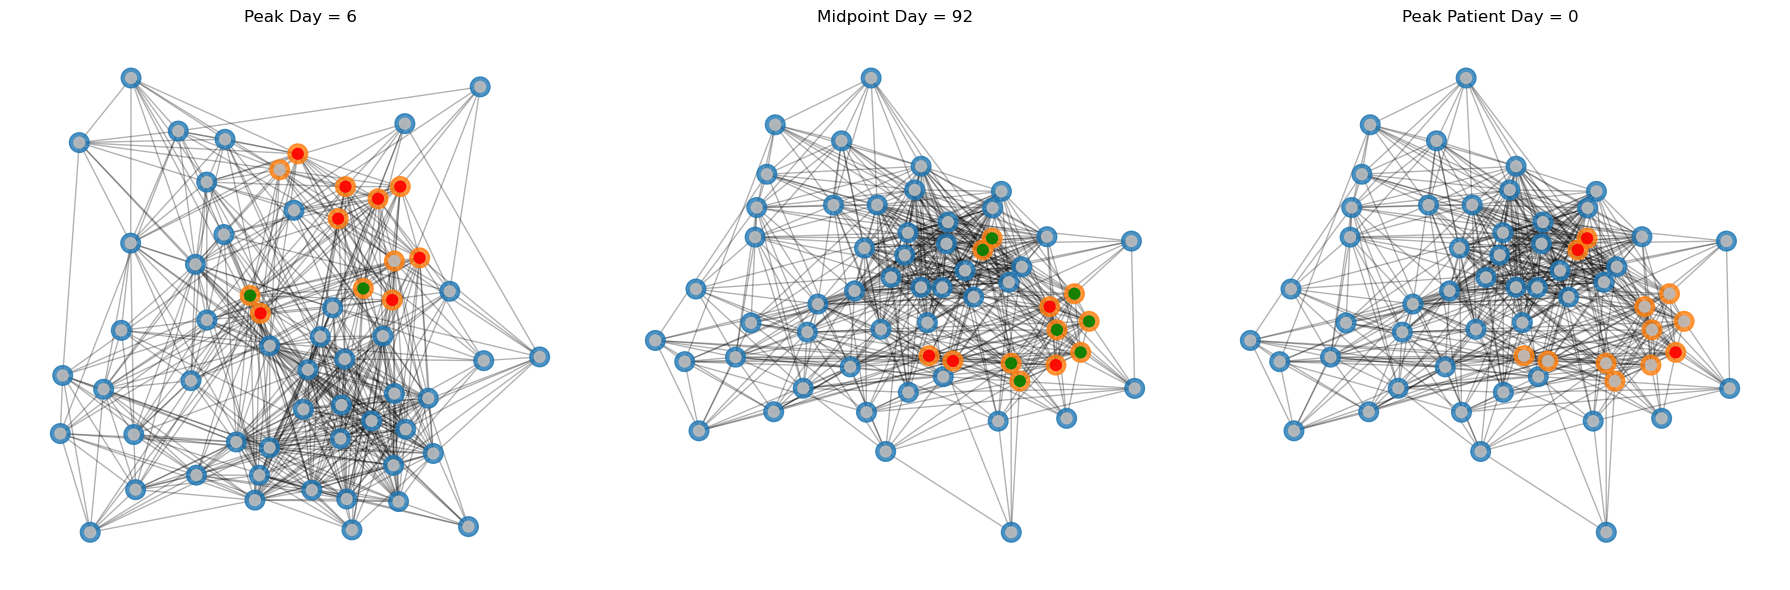

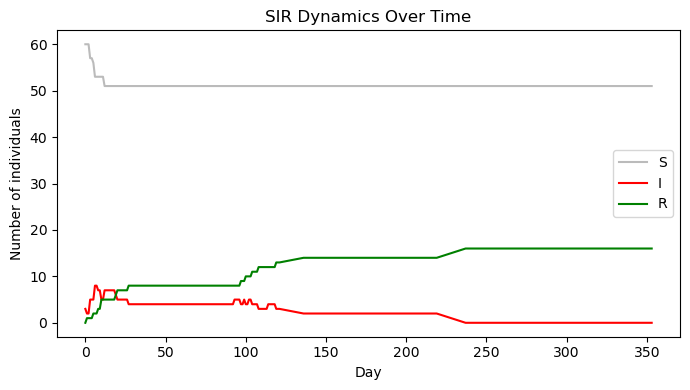

In [41]:
import numpy as np
import random 
from collections import defaultdict 
import pandas as pd 
import matplotlib.pyplot as plt
import networkx as nx 


# ============================================================
# ORIGINAL SIR SIMULATION + NETWORK STATES
# ============================================================

agents_pd = agents_df.to_pandas()
agents = dict(zip(agents_pd["agent_id"], agents_pd["role"]))

days = sorted({int(d) for (d, _) in roster.keys()})
EARLY = days[0]
all_agents = set(agents.keys())
state = {a: "S" for a in all_agents}

first_day_agents = {a for (d, _), ppl in roster.items() if d == EARLY for a in ppl}
active_agents = {a for (_, _), ppl in roster.items() for a in ppl}
seed_pool = list(first_day_agents or active_agents or all_agents)

for a in random.sample(seed_pool, min(3, len(seed_pool))):
    state[a] = "I"

beta_env = 0.02
shed_rate = {"NURSE": 0.5, "PATIENT": 1.0}
half_life_days = 45.0
decay = 1.0 - (0.5 ** (1.0 / half_life_days))
recovery = 1.0 / 14.0

room_load = defaultdict(float)
daily_stats = []
states_by_day = {}

for d in days:
    # shedding
    for (day_key, room), people in roster.items():
        if day_key != d: 
            continue
        for a in people:
            if state.get(a, "S") == "I":
                role = agents.get(a, "PATIENT")
                room_load[room] += shed_rate[role]

    # infections
    for (day_key, room), people in roster.items():
        if day_key != d:
            continue
        L = room_load[room]
        p_inf = 1.0 - np.exp(-beta_env * L)
        for a in people:
            if state.get(a, "S") == "S" and random.random() < p_inf:
                state[a] = "I"

    # recovery
    for a in list(state.keys()):
        if state[a] == "I" and random.random() < recovery:
            state[a] = "R"

    # environmental decay
    for r in room_load:
        room_load[r] *= (1.0 - decay)

    S_count = sum(s == "S" for s in state.values())
    I_count = sum(s == "I" for s in state.values())
    R_count = sum(s == "R" for s in state.values())

    daily_stats.append({"day": d, "S": S_count, "I": I_count, "R": R_count})
    states_by_day[d] = state.copy()

epi = pd.DataFrame(daily_stats)
peak_idx = epi["I"].idxmax()
peak_day = epi.loc[peak_idx, "day"]
state_peak = states_by_day[peak_day]

# ============================================================
# BUILD ALL THREE SUBGRAPHS
# ============================================================

# ---------- Peak-day subgraph ----------
if G.number_of_nodes() > 60:
    deg_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)
    top_nodes = [n for n, d in deg_sorted[:60]]
    H = G.subgraph(top_nodes).copy()
else:
    H = G

pos = nx.spring_layout(H, seed=0)

role_colors = ["tab:blue" if H.nodes[n]["role"] == "PATIENT" else "tab:orange" for n in H.nodes()]
state_colors = [
    "red" if state_peak.get(n, "S") == "I"
    else "green" if state_peak.get(n, "S") == "R"
    else "#BBBBBB"
    for n in H.nodes()
]


# ---------- Midpoint subgraph ----------
infected_days = epi.loc[epi["I"] > 0, "day"].tolist()
if infected_days:
    mid_day = infected_days[len(infected_days)//2]
else:
    mid_day = days[len(days)//2]
state_mid = states_by_day[mid_day]

if G.number_of_nodes() > 60:
    deg_sorted_mid = sorted(G.degree, key=lambda x: x[1])
    top_nodes_mid = [n for n, d in deg_sorted_mid[-60:]]
    H_mid = G.subgraph(top_nodes_mid).copy()
else:
    H_mid = G

pos_mid = nx.spring_layout(H_mid, seed=0)
role_colors_mid = ["tab:blue" if H_mid.nodes[n]["role"] == "PATIENT" else "tab:orange" for n in H_mid.nodes()]
state_colors_mid = [
    "red" if state_mid.get(n, "S") == "I"
    else "green" if state_mid.get(n, "S") == "R"
    else "#BBBBBB"
    for n in H_mid.nodes()
]


# ---------- Patient-peak subgraph ----------
role_map = agents
best_day = None
best_pat_I = -1

for d, snapshot in states_by_day.items():
    I_pat = sum((snapshot.get(a, "S") == "I") and (role_map.get(a) == "PATIENT") for a in snapshot)
    if I_pat > best_pat_I:
        best_pat_I = I_pat
        best_day = d
state_pat = states_by_day[best_day]

if G.number_of_nodes() > 60:
    deg_sorted_pat = sorted(G.degree, key=lambda x: x[1])
    top_nodes_pat = [n for n, d in deg_sorted_pat[-60:]]
    H_pat = G.subgraph(top_nodes_pat).copy()
else:
    H_pat = G

pos_pat = nx.spring_layout(H_pat, seed=0)
role_colors_pat = ["tab:blue" if H_pat.nodes[n]["role"] == "PATIENT" else "tab:orange" for n in H_pat.nodes()]
state_colors_pat = [
    "red" if state_pat.get(n, "S") == "I"
    else "green" if state_pat.get(n, "S") == "R"
    else "#BBBBBB"
    for n in H_pat.nodes()
]


# ============================================================
# COMBINE ALL THREE NETWORK PLOTS SIDE BY SIDE
# ============================================================

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# --- Peak day ---
nx.draw_networkx_nodes(H, pos, node_color=role_colors, node_size=200, ax=axs[0], alpha=0.8)
nx.draw_networkx_edges(H, pos, ax=axs[0], alpha=0.3)
nx.draw_networkx_nodes(H, pos, node_color=state_colors, node_size=60, ax=axs[0], alpha=0.9)
axs[0].set_title(f"Peak Day = {peak_day}")
axs[0].axis("off")

# --- Midpoint ---
nx.draw_networkx_nodes(H_mid, pos_mid, node_color=role_colors_mid, node_size=200, ax=axs[1], alpha=0.8)
nx.draw_networkx_edges(H_mid, pos_mid, ax=axs[1], alpha=0.3)
nx.draw_networkx_nodes(H_mid, pos_mid, node_color=state_colors_mid, node_size=60, ax=axs[1], alpha=0.9)
axs[1].set_title(f"Midpoint Day = {mid_day}")
axs[1].axis("off")

# --- Peak patient infection ---
nx.draw_networkx_nodes(H_pat, pos_pat, node_color=role_colors_pat, node_size=200, ax=axs[2], alpha=0.8)
nx.draw_networkx_edges(H_pat, pos_pat, ax=axs[2], alpha=0.3)
nx.draw_networkx_nodes(H_pat, pos_pat, node_color=state_colors_pat, node_size=60, ax=axs[2], alpha=0.9)
axs[2].set_title(f"Peak Patient Day = {best_day}")
axs[2].axis("off")

plt.tight_layout()
plt.show()


# ============================================================
# SIR TIME SERIES
# ============================================================

plt.figure(figsize=(7, 4))
plt.plot(epi["day"], epi["S"], color="#BBBBBB", label="S")
plt.plot(epi["day"], epi["I"], color="red", label="I")
plt.plot(epi["day"], epi["R"], color="green", label="R")
plt.xlabel("Day")
plt.ylabel("Number of individuals")
plt.title("SIR Dynamics Over Time")
plt.legend()
plt.tight_layout()
plt.show()



Busiest rooms: [('1', 364), ('90400', 45), ('973', 38)]
Lockdown targets: {'1', '973', '90400'}


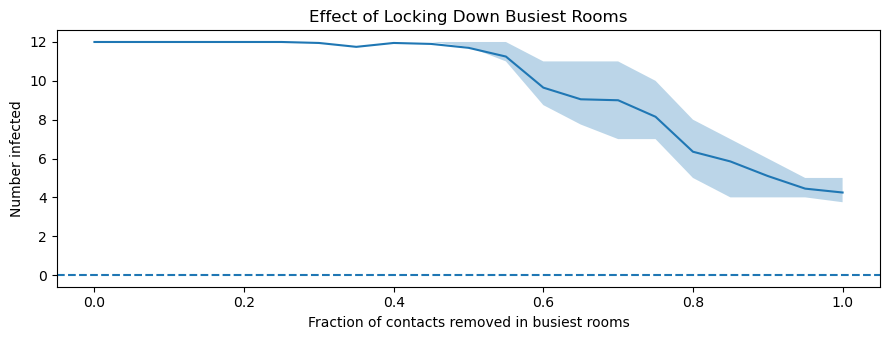

In [42]:
# ============================================================
# INTERVENTION EXPERIMENT — LOCK DOWN BUSIEST ROOMS
# ============================================================

def run_env_SIR_on_roster(roster_local, agents_df,
                          beta_env=beta_env,
                          shed_rate=shed_rate,
                          half_life_days=half_life_days,
                          recovery=recovery,
                          n_seed=3,
                          seed=None):

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    agents_pd_local = agents_df.to_pandas()
    agents_local = dict(zip(agents_pd_local["agent_id"], agents_pd_local["role"]))

    days_local = sorted({int(d) for (d, _) in roster_local.keys()})
    EARLY_local = days_local[0]
    all_agents_local = set(agents_local.keys())
    state_local = {a: "S" for a in all_agents_local}

    first_day_agents_local = {a for (d, _), ppl in roster_local.items()
                              if d == EARLY_local for a in ppl}
    active_agents_local = {a for (_, _), ppl in roster_local.items()
                           for a in ppl}
    seed_pool_local = list(first_day_agents_local or active_agents_local or all_agents_local)

    for a in random.sample(seed_pool_local, min(n_seed, len(seed_pool_local))):
        state_local[a] = "I"

    decay_local = 1.0 - (0.5 ** (1.0 / half_life_days))
    room_load_local = defaultdict(float)
    daily_stats_local = []

    for d in days_local:
        for (day_key, room), people in roster_local.items():
            if day_key != d:
                continue
            for a in people:
                if state_local.get(a, "S") == "I":
                    role = agents_local.get(a, "PATIENT")
                    room_load_local[room] += shed_rate[role]

        for (day_key, room), people in roster_local.items():
            if day_key != d:
                continue
            L = room_load_local[room]
            p_inf = 1.0 - np.exp(-beta_env * L)
            for a in people:
                if state_local.get(a, "S") == "S" and random.random() < p_inf:
                    state_local[a] = "I"

        for a in list(state_local.keys()):
            if state_local[a] == "I" and random.random() < recovery:
                state_local[a] = "R"

        for r in room_load_local:
            room_load_local[r] *= (1 - decay_local)

        S_count_local = sum(s == "S" for s in state_local.values())
        I_count_local = sum(s == "I" for s in state_local.values())
        R_count_local = sum(s == "R" for s in state_local.values())

        daily_stats_local.append({
            "day": d,
            "S": S_count_local,
            "I": I_count_local,
            "R": R_count_local
        })

    return pd.DataFrame(daily_stats_local)


def lockdown_roster(roster_base, wing_rooms, frac_remove):
    new_roster = {}
    for (day, room), people in roster_base.items():
        if room not in wing_rooms:
            new_roster[(day, room)] = list(people)
        else:
            kept = [a for a in people if random.random() > frac_remove]
            if kept:
                new_roster[(day, room)] = kept
    return new_roster


# --- pick busiest rooms automatically ---
room_counts = defaultdict(int)
for (day, room), people in roster.items():
    room_counts[room] += len(people)

k_top = 3
top_rooms = sorted(room_counts.items(), key=lambda x: x[1], reverse=True)[:k_top]
wing_rooms = {room for room, _ in top_rooms}

print("Busiest rooms:", top_rooms)
print("Lockdown targets:", wing_rooms)

# --- run experiment ---
fractions = np.linspace(0.0, 1.0, 21)
n_runs = 20
results = []

for f in fractions:
    infected_list = []
    for r in range(n_runs):
        locked = lockdown_roster(roster, wing_rooms, frac_remove=f)
        epi_test = run_env_SIR_on_roster(locked, agents_df, seed=1000+r)
        N = epi_test[["S","I","R"]].iloc[0].sum()
        final_S = epi_test["S"].iloc[-1]
        infected_list.append(N - final_S)

    results.append({
        "frac_removed": f,
        "mean_I": np.mean(infected_list),
        "q25_I": np.quantile(infected_list, 0.25),
        "q75_I": np.quantile(infected_list, 0.75),
    })

results_df = pd.DataFrame(results)

# --- plot effect of lockdown ---
plt.figure(figsize=(9, 3.5))

plt.plot(results_df["frac_removed"], results_df["mean_I"])
plt.fill_between(results_df["frac_removed"],
                 results_df["q25_I"], results_df["q75_I"], alpha=0.3)
plt.axhline(0, linestyle="--")

plt.xlabel("Fraction of contacts removed in busiest rooms")
plt.ylabel("Number infected")
plt.title("Effect of Locking Down Busiest Rooms")
plt.tight_layout()
plt.show()
